# Lab 8

- Daniel Alfredo Rayo Roldan
- Flavio Galan
- Maria Fernanda
- Irving Fabricio

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Análisis exploratorio

Para este reporte se esta trabajandon registros de ventas hechas en para diferentes articulos, en diferentes sucursales, el objetivo es poder desarrollar un modelo temporal que pueda predecir las ventas para los diferentes articulos, para ello una comprensión de los datos con lo que se trabajó fue importante.

In [10]:
df = pd.read_csv("/train.csv")

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['date', 'store', 'item']).reset_index(drop=True)

ValueError: time data "20" doesn't match format "%Y-%m-%d", at position 610137. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Un primer acercamiento nos indica que estamos trabajando con un dataset de 4 variables y 913,000 registros:

- `date`: Fecha en que se registren las ventas.
- `store`: ID de la tienda en que se hicieron las ventas.
- `item`: ID del item del que se registro ventas.
- `sales`: Cantidad de articulos vendidos.

In [11]:
print("Dimensiones del dataframe:", df.shape)
print("\nPrimeras filas:")
print(df.head())

Dimensiones del dataframe: (610138, 4)

Primeras filas:
         date  store  item  sales
0  2013-01-01    1.0   1.0   13.0
1  2013-01-02    1.0   1.0   11.0
2  2013-01-03    1.0   1.0   14.0
3  2013-01-04    1.0   1.0   13.0
4  2013-01-05    1.0   1.0   10.0


Se pudo observar que todos las variables que las primeras 3 variables son categóricas aunque representadas númericamente en pandas.

In [5]:
print("\nInformacion de Data:")
print(df.info())


Informacion de Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610138 entries, 0 to 610137
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    610138 non-null  object 
 1   store   610137 non-null  float64
 2   item    610137 non-null  float64
 3   sales   610137 non-null  float64
dtypes: float64(3), object(1)
memory usage: 18.6+ MB
None


Se cuentan con registros desde el 1 de enero de 203 hasta el 31 de diciembre de 2017 que comprende los datos de 10 articulos y 50 tiendas.

In [6]:
print("\nRango de Fechas:", df['date'].min(), "to", df['date'].max())
print("\nNumero de tiendas:", df['store'].nunique())
print("\nNumero de items:", df['item'].nunique())


Rango de Fechas: 20 to 2017-12-31

Numero de tiendas: 10

Numero de items: 34


Además parece que la cantidad de datos esta balanceada para cada combinacion de tiendas y artículos, garantizando que el modelo no beneficiara más unos patrones que otros.

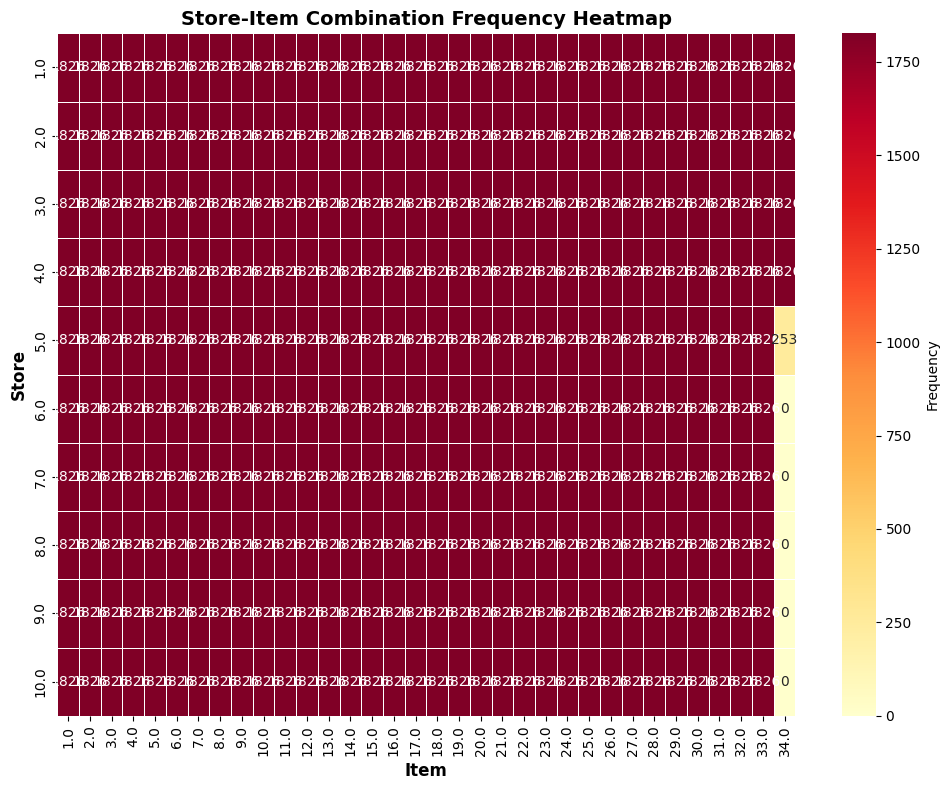

In [7]:
def plot_store_item_heatmap(df, figsize=(10, 8)):
    # Count frequency for each combination
    freq_matrix = df.groupby(['store', 'item']).size().unstack(fill_value=0)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(freq_matrix, annot=True, fmt='d', cmap='YlOrRd',
                linewidths=0.5, cbar_kws={'label': 'Frequency'})

    plt.xlabel('Item', fontsize=12, fontweight='bold')
    plt.ylabel('Store', fontsize=12, fontweight='bold')
    plt.title('Store-Item Combination Frequency Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
plot_store_item_heatmap(df)

Por último y muy importante, no parece haber datos nulos en ninguno de los registros.

In [ ]:
print("Valores nulos")
df.isna().sum()

Valores nulos


,0
date,0
store,0
item,0
sales,0


In [ ]:
duplicates = df.duplicated(subset=['date', 'store', 'item'])
print(f"\nFilas duplicadas: {duplicates.sum()}")


Filas duplicadas: 0


# Limpieza de datos

Para la limpieza de datos, dado que se corroboro que no habian datos nulos o vacios, la única preocupación era que pudieran no haber fechas registradas para alguno articulo y tienda, así que las fechas vacios fueron llenas con la combinación e indicando que ese día se hicieron 0 ventas.

In [ ]:
min_date = df['date'].min()
max_date = df['date'].max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

stores = df['store'].unique()
items = df['item'].unique()

complete_index = pd.MultiIndex.from_product(
    [all_dates, stores, items],
    names=['date', 'store', 'item']
)
df_complete = pd.DataFrame(index=complete_index).reset_index()

df_complete = df_complete.merge(df, on=['date', 'store', 'item'], how='left')

In [ ]:
def plot_item_all_stores(df, item_id, max_stores=10, figsize=(15, 10)):
    # Filter data for the item
    item_data = df[df['item'] == item_id]
    stores = sorted(item_data['store'].unique())[:max_stores]

    n_stores = len(stores)
    n_cols = 2
    n_rows = (n_stores + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_stores > 1 else [axes]

    for idx, store_id in enumerate(stores):
        data = item_data[item_data['store'] == store_id].sort_values('date')

        ax = axes[idx]
        ax.plot(data['date'], data['sales'], linewidth=1, alpha=0.7)

        # Add 7-day moving average
        rolling_mean = data['sales'].rolling(window=7, center=True).mean()
        ax.plot(data['date'], rolling_mean, linewidth=2, color='red', alpha=0.7)

        ax.set_title(f'Tienda {store_id}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Fecha', fontsize=9)
        ax.set_ylabel('Ventas', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

    # Hide extra subplots
    for idx in range(n_stores, len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f'Todas las tiendas - Item {item_id}', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

Se pensaba en aplicar un diferenciación pero dado que no se presenta una tendencia muy fuerte, como se ve en las gráficas de abajo, además que se estará trabajando con redes neuronales se omitió la idea.

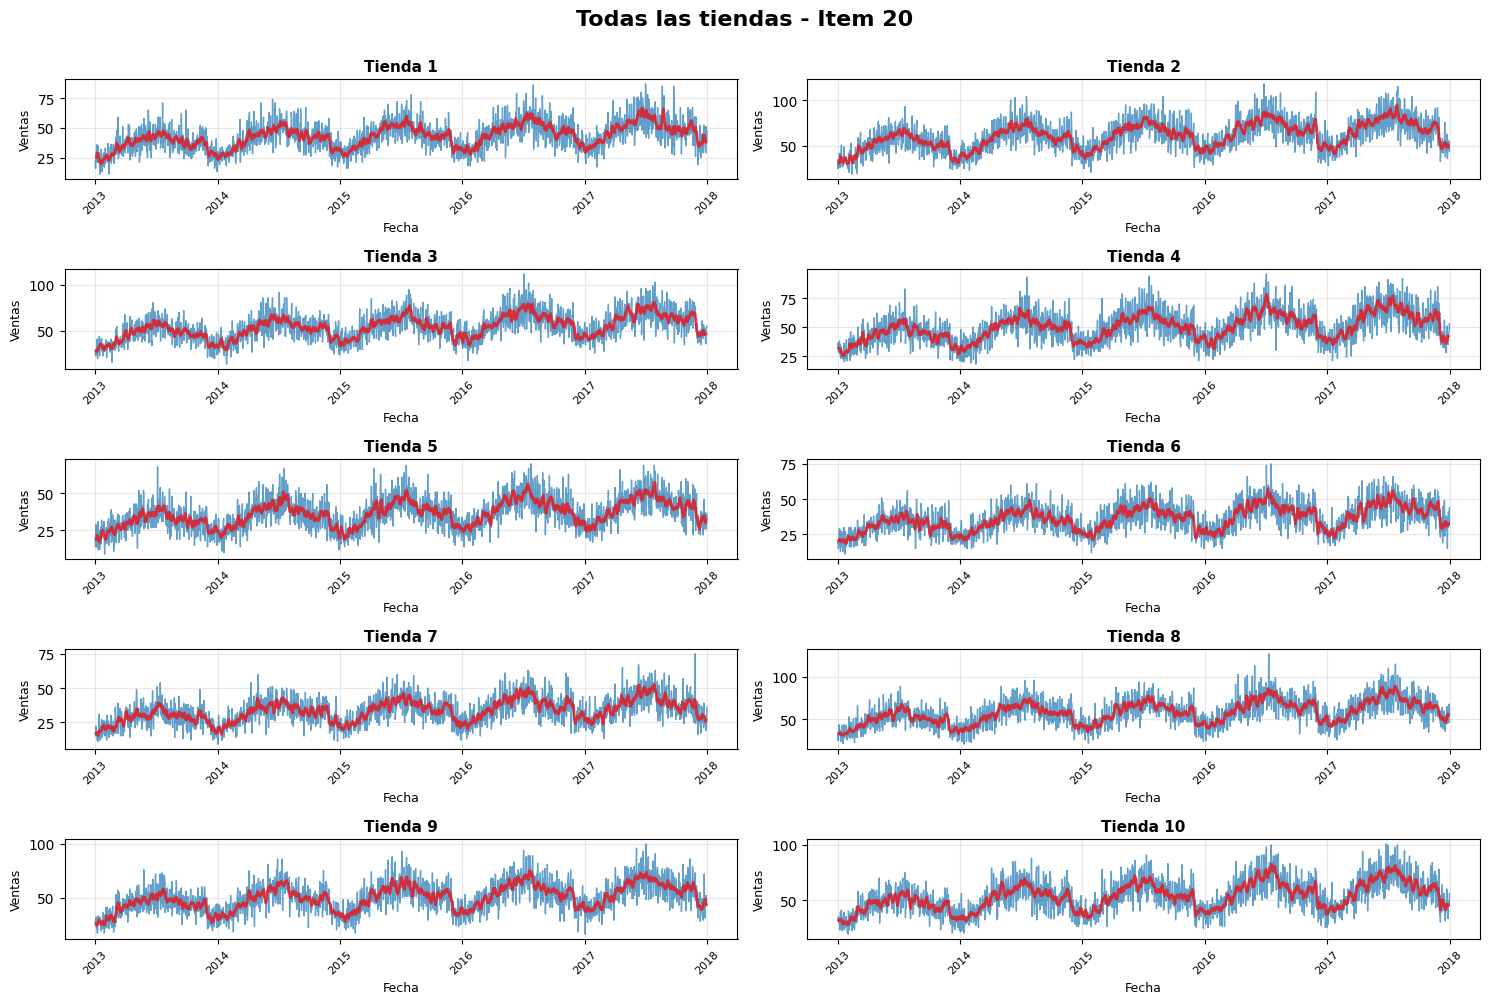

In [ ]:
plot_item_all_stores(df_complete, 20)

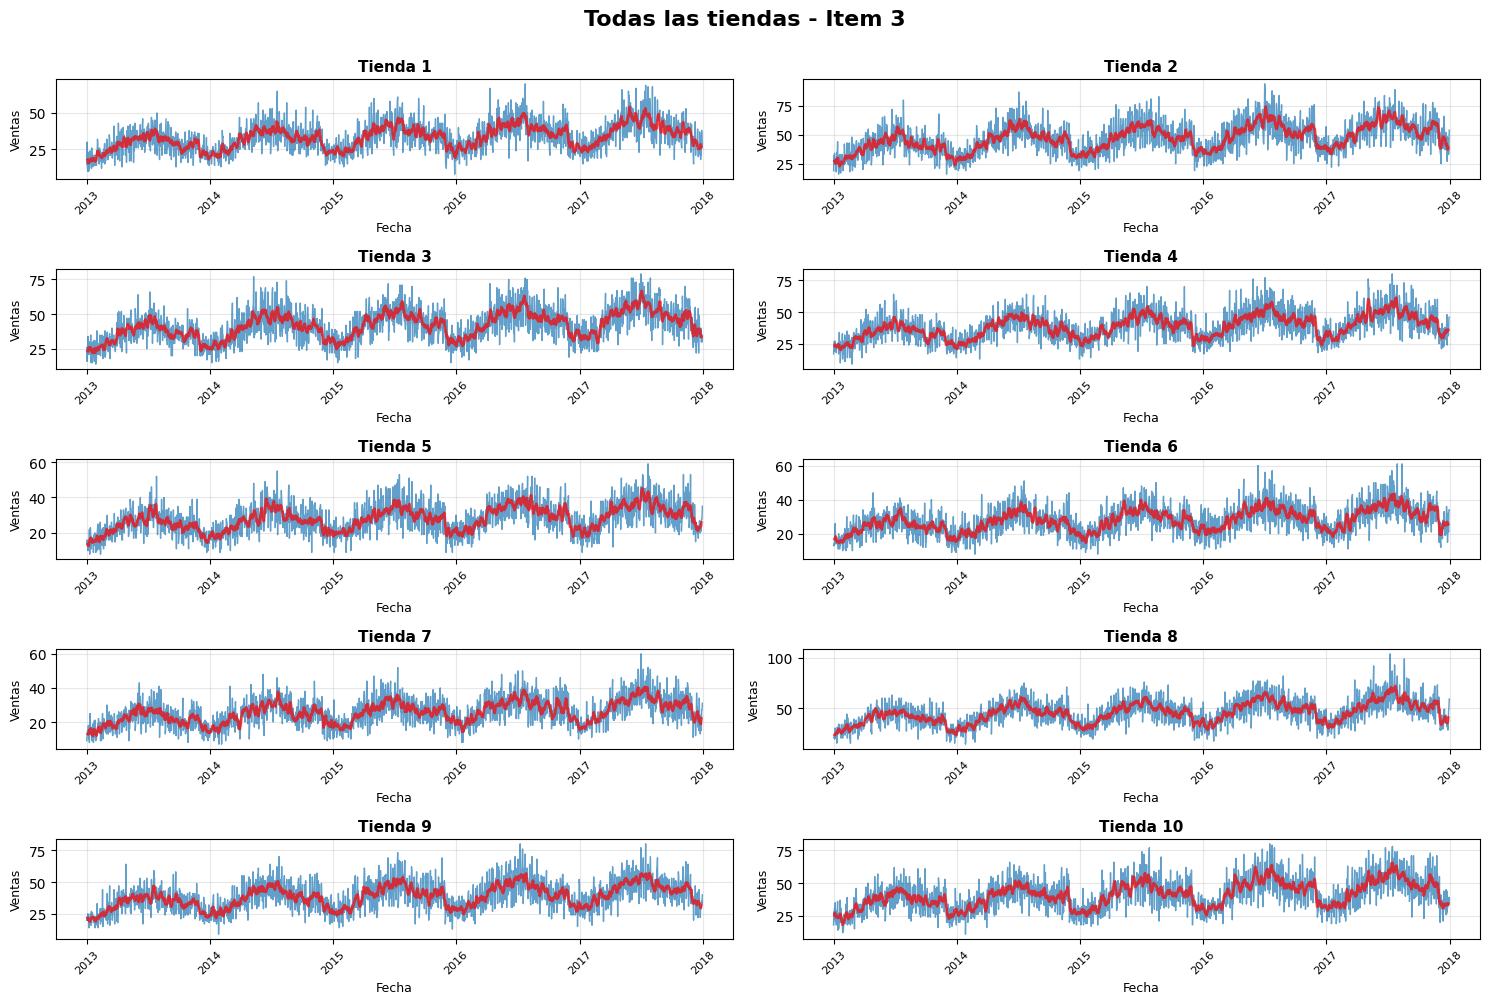

In [ ]:
plot_item_all_stores(df_complete, 3)

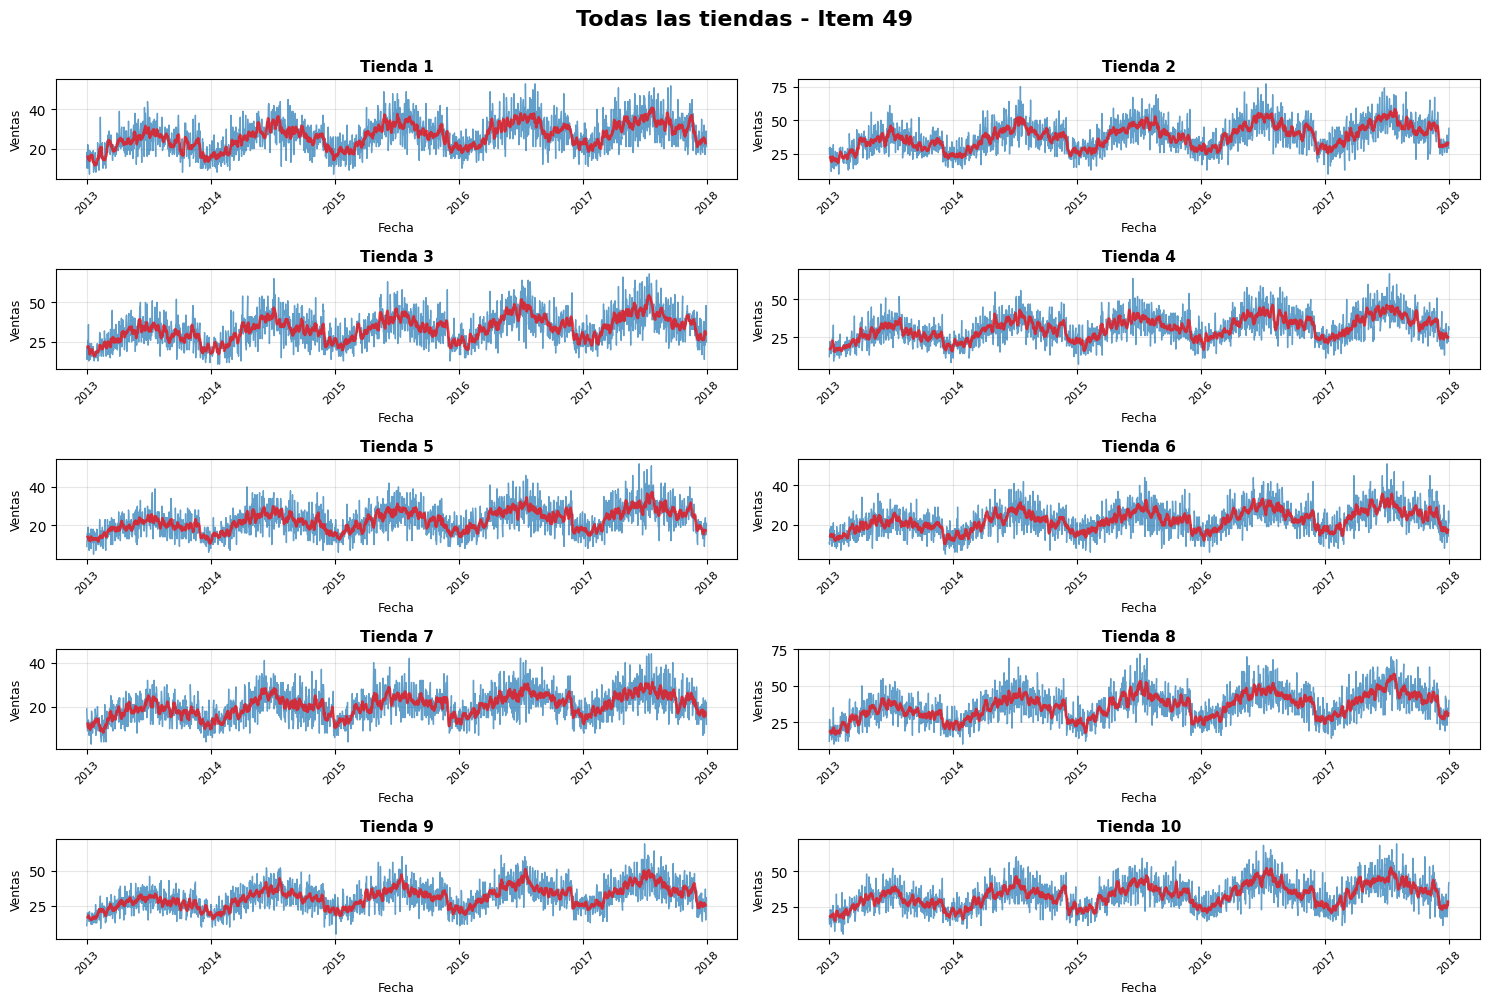

In [ ]:
plot_item_all_stores(df_complete, 49)

## Modelo de Predicción

Tomando en cuenta los hallazgos del análisis exploratorio previo, se observo que todos los artículos presentaban serias temporal muy parecidas a lo largo de la fechas, además de presentar estacionalidad muy marcada, se decidió utilizar redes GRU (**Gated Recurrent Units**), al ser modelos más simples que los los LSTM y por requiriendo menos computo y tiempo de entrenamiento, siendo útiles cuando los datos no presentan comportamientos muy complejos.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import multiprocessing

# Configuración de semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ============================================================================


def load_and_prepare_data(filepath):
    """Carga y prepara los datos de ventas"""
    df = pd.read_csv(filepath)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["store", "item", "date"])
    return df


def create_sequences(data, seq_length=60):
    """
    Crea secuencias temporales para el modelo GRU

    Args:
        data: Array con los datos de ventas
        seq_length: Longitud de la secuencia de entrada (días históricos)

    Returns:
        X: Secuencias de entrada
        y: Valores objetivo (siguiente punto)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def prepare_dataset(df, seq_length=60, forecast_horizon=90):
    """
    Prepara el dataset completo para todas las combinaciones store-item

    Args:
        df: DataFrame con los datos
        seq_length: Días históricos para predicción
        forecast_horizon: Días a predecir (3 meses = ~90 días)
    """
    scalers = {}
    X_all, y_all = [], []
    store_item_info = []

    # Procesar cada combinación de tienda e item
    for store in df["store"].unique():
        for item in df["item"].unique():
            # Filtrar datos para esta combinación
            mask = (df["store"] == store) & (df["item"] == item)
            sales_data = df[mask]["sales"].values.reshape(-1, 1)

            # Verificar que hay suficientes datos
            if len(sales_data) < seq_length + forecast_horizon:
                continue

            # Normalizar datos
            scaler = MinMaxScaler(feature_range=(0, 1))
            sales_scaled = scaler.fit_transform(sales_data)

            # Guardar scaler para desnormalización posterior
            scalers[(store, item)] = scaler

            # Crear secuencias
            X, y = create_sequences(sales_scaled, seq_length)

            X_all.append(X)
            y_all.append(y)
            store_item_info.extend([(store, item)] * len(X))

    X_all = np.vstack(X_all)
    y_all = np.vstack(y_all)

    return X_all, y_all, scalers, store_item_info


# ============================================================================
# 2. CONSTRUCCIÓN DEL MODELO GRU
# ============================================================================


def build_gru_model(seq_length, n_features=1):
    """
    Construye un modelo GRU para predicción de series temporales

    Arquitectura:
    - 2 capas GRU con dropout
    - Capas densas para la predicción final
    """
    model = keras.Sequential(
        [
            # Primera capa GRU
            layers.GRU(
                128,
                return_sequences=True,
                input_shape=(seq_length, n_features),
                activation="tanh",
            ),
            layers.Dropout(0.2),
            # Segunda capa GRU
            layers.GRU(64, return_sequences=False, activation="tanh"),
            layers.Dropout(0.2),
            # Capas densas
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(16, activation="relu"),
            layers.Dense(1),
        ]
    )

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae"],
    )

    return model


# ============================================================================
# 3. ENTRENAMIENTO
# ============================================================================


def train_model(
    model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, patience=10
):
    """Entrena el modelo con callbacks"""

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001
    )

    # Entrenamiento
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
    )

    return history


# ============================================================================
# 4. PREDICCIÓN DE 3 MESES
# ============================================================================


def predict_future(model, last_sequence, scaler, n_days=90):
    """
    Predice los próximos n_days usando predicción iterativa

    Args:
        model: Modelo GRU entrenado
        last_sequence: Última secuencia conocida (normalizada)
        scaler: Scaler para desnormalizar
        n_days: Número de días a predecir

    Returns:
        predictions: Array con las predicciones desnormalizadas
    """
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(n_days):
        # Predecir siguiente punto
        pred = model.predict(current_seq.reshape(1, -1, 1), verbose=0)
        predictions.append(pred[0, 0])

        # Actualizar secuencia (eliminar primer valor, agregar predicción)
        current_seq = np.append(current_seq[1:], pred[0, 0])

    # Desnormalizar predicciones
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    return predictions.flatten()

def predItem(model, df, scalers, seq_length, forecast_days, store, item):
    if (store,item) not in scalers:
        return pd.DataFrame()

    # Obtener últimos datos
    mask = (df["store"] == store) & (df["item"] == item)
    sales_data = df[mask]["sales"].values.reshape(-1, 1)

    # Normalizar
    scaler = scalers[(store, item)]
    sales_scaled = scaler.transform(sales_data)

    # Tomar última secuencia
    last_seq = sales_scaled[-seq_length:]

    # Predecir
    predictions = predict_future(model, last_seq, scaler, forecast_days)

    # Crear DataFrame con predicciones
    future_dates = [
        last_date + timedelta(days=i + 1) for i in range(forecast_days)
    ]

    pred_df = pd.DataFrame(
        {
            "date": future_dates,
            "store": store,
            "item": item,
            "predicted_sales": predictions,
        }
    )


def generate_all_predictions(model, df, scalers, seq_length=60, forecast_days=90, maxItems=50):
    """
    Genera predicciones para todas las combinaciones store-item

    Returns:
        DataFrame con las predicciones
    """
    all_predictions = []

    # Última fecha en los datos
    last_date = df["date"].max()

    uniqueStores = df["store"].unique()
    uniqueItems = df["item"].unique()

    for store in uniqueStores:
        print("Predicting store:", store, "of:", len(uniqueStores))
        for item in uniqueItems[:maxItems]:
            if (store, item) not in scalers:
                continue

            # Obtener últimos datos
            mask = (df['store'] == store) & (df['item'] == item)
            sales_data = df[mask]['sales'].values.reshape(-1, 1)

            # Normalizar
            scaler = scalers[(store, item)]
            sales_scaled = scaler.transform(sales_data)

            # Tomar última secuencia
            last_seq = sales_scaled[-seq_length:]

            # Predecir
            predictions = predict_future(model, last_seq, scaler, forecast_days)

            # Crear DataFrame con predicciones
            future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

            pred_df = pd.DataFrame({
                'date': future_dates,
                'store': store,
                'item': item,
                'predicted_sales': predictions
            })

            all_predictions.append(pred_df)
        # pred = pool.map(predItem,
        #                 [(model, df, scalers, seq_length, forecast_days, store, it) for it in uniqueItems[:maxItems]]
        # )
        # pred = pool.map(lambda item: predItem(model, df, scalers, seq_length, forecast_days, maxItems, store, item), uniqueItems[:maxItems])
        # all_predictions.extend(pred)

    return pd.concat(all_predictions, ignore_index=True)


# ============================================================================
# 5. VISUALIZACIÓN
# ============================================================================


def plot_predictions(df, predictions_df, store=1, item=1):
    """Visualiza predicciones para una combinación store-item"""

    # Datos históricos
    mask = (df["store"] == store) & (df["item"] == item)
    historical = df[mask].tail(180)  # Últimos 6 meses

    # Predicciones
    mask_pred = (predictions_df["store"] == store) & (predictions_df["item"] == item)
    future = predictions_df[mask_pred]

    plt.figure(figsize=(15, 6))
    plt.plot(
        historical["date"], historical["sales"], label="Ventas Históricas", linewidth=2
    )
    plt.plot(
        future["date"],
        future["predicted_sales"],
        label="Predicción 3 Meses",
        linewidth=2,
        linestyle="--",
        color="red",
    )

    plt.axvline(
        x=historical["date"].max(),
        color="green",
        linestyle=":",
        label="Inicio Predicción",
    )

    plt.title(f"Predicción de Ventas - Tienda {store}, Artículo {item}", fontsize=14)
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    """Visualiza el proceso de entrenamiento"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history.history["loss"], label="Train Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Pérdida del Modelo")
    ax1.set_xlabel("Época")
    ax1.set_ylabel("MSE")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # MAE
    ax2.plot(history.history["mae"], label="Train MAE")
    ax2.plot(history.history["val_mae"], label="Validation MAE")
    ax2.set_title("Error Absoluto Medio")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("MAE")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================================
# 6. PIPELINE COMPLETO
# ============================================================================
print("=" * 70)
print("MODELO GRU PARA PREDICCIÓN DE VENTAS")
print("=" * 70)

# Parámetros
SEQ_LENGTH = 60  # 2 meses de historia
FORECAST_DAYS = 90  # 3 meses de predicción

# 1. Cargar datos
print("\n1. Cargando datos...")
df = df_complete
print(f"   Datos cargados: {len(df)} registros")
print(f"   Tiendas: {df['store'].nunique()}, Artículos: {df['item'].nunique()}")
print(f"   Rango de fechas: {df['date'].min()} a {df['date'].max()}")

# 2. Preparar dataset
print("\n2. Preparando secuencias temporales...")
X, y, scalers, store_item_info = prepare_dataset(df, SEQ_LENGTH, FORECAST_DAYS)
print(f"   Secuencias creadas: {len(X)}")
print(f"   Forma de X: {X.shape}")

# 3. Split train/validation
print("\n3. Dividiendo datos...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"   Train: {len(X_train)}, Validation: {len(X_val)}")

MODELO GRU PARA PREDICCIÓN DE VENTAS

1. Cargando datos...
   Datos cargados: 913000 registros
   Tiendas: 10, Artículos: 50
   Rango de fechas: 2013-01-01 00:00:00 a 2017-12-31 00:00:00

2. Preparando secuencias temporales...
   Secuencias creadas: 883000
   Forma de X: (883000, 60, 1)

3. Dividiendo datos...
   Train: 706400, Validation: 176600



4. Construyendo modelo GRU...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,337 (368.50 KB)

 Trainable params: 94,337 (368.50 KB)

 Non-trainable params: 0 (0.00 B)

None

5. Entrenando modelo...
Epoch 1/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 225s 10ms/step - loss: 0.0117 - mae: 0.0835 - val_loss: 0.0090 - val_mae: 0.0742 - learning_rate: 0.0010
Epoch 2/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 220s 10ms/step - loss: 0.0092 - mae: 0.0751 - val_loss: 0.0088 - val_mae: 0.0734 - learning_rate: 0.0010
Epoch 3/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 221s 10ms/step - loss: 0.0103 - mae: 0.0790 - val_loss: 0.0110 - val_mae: 0.0817 - learning_rate: 0.0010
Epoch 4/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 222s 10ms/step - loss: 0.0109 - mae: 0.0816 - val_loss: 0.0102 - val_mae: 0.0788 - learning_rate: 0.0010

6. Visualizando resultados de entrenamiento...


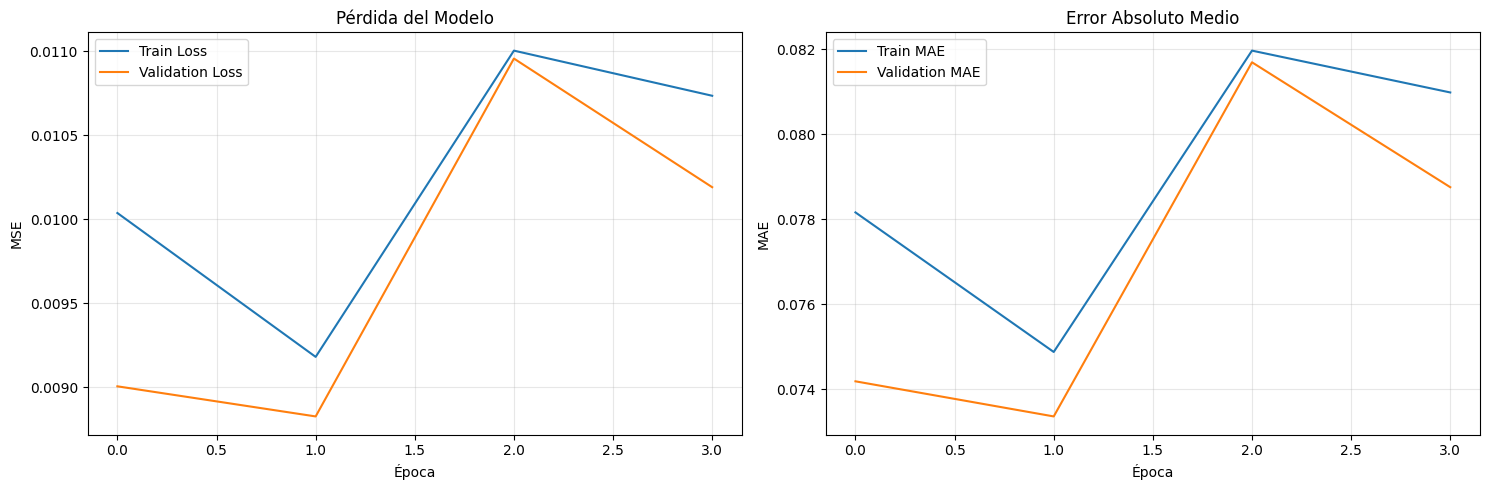

In [ ]:
# 4. Construir modelo
print("\n4. Construyendo modelo GRU...")
model = build_gru_model(SEQ_LENGTH)
print(model.summary())

# 5. Entrenar
print("\n5. Entrenando modelo...")
history = train_model(model, X_train, y_train, X_val, y_val, epochs=10, patience=2)

# 6. Visualizar entrenamiento
print("\n6. Visualizando resultados de entrenamiento...")
plot_training_history(history)

In [ ]:
# 7. Generar predicciones
print("\n7. Generando predicciones para 3 meses...")
maxItems = 10
predictions_df = generate_all_predictions(model, df, scalers, SEQ_LENGTH, FORECAST_DAYS, maxItems=maxItems)
print(f"   Predicciones generadas: {len(predictions_df)} registros")

# 8. Guardar predicciones
predictions_df.to_csv('predicciones_3_meses.csv', index=False)
print("\n8. Predicciones guardadas en 'predicciones_3_meses.csv'")


7. Generando predicciones para 3 meses...
Predicting store: 1 of: 10
Predicting store: 2 of: 10
Predicting store: 3 of: 10
Predicting store: 4 of: 10
Predicting store: 5 of: 10
Predicting store: 6 of: 10
Predicting store: 7 of: 10
Predicting store: 8 of: 10
Predicting store: 9 of: 10
Predicting store: 10 of: 10
   Predicciones generadas: 9000 registros

8. Predicciones guardadas en 'predicciones_3_meses.csv'



9. Visualizando ejemplos de predicciones...


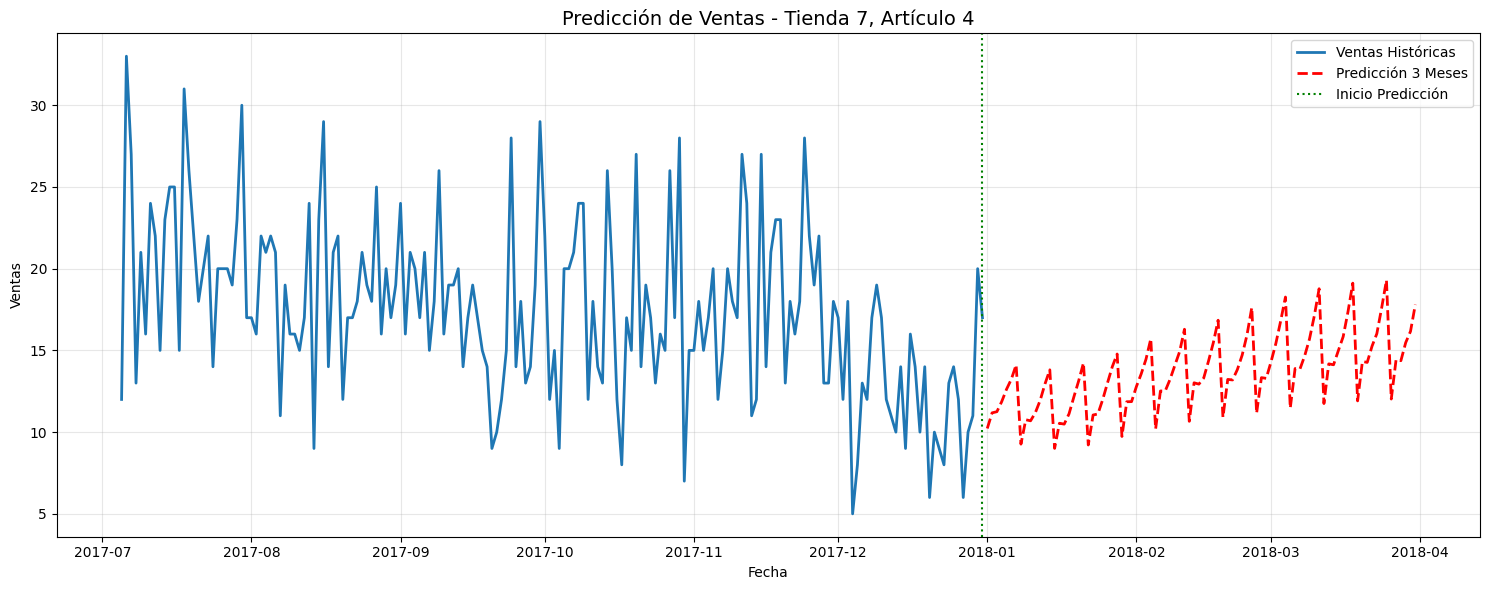

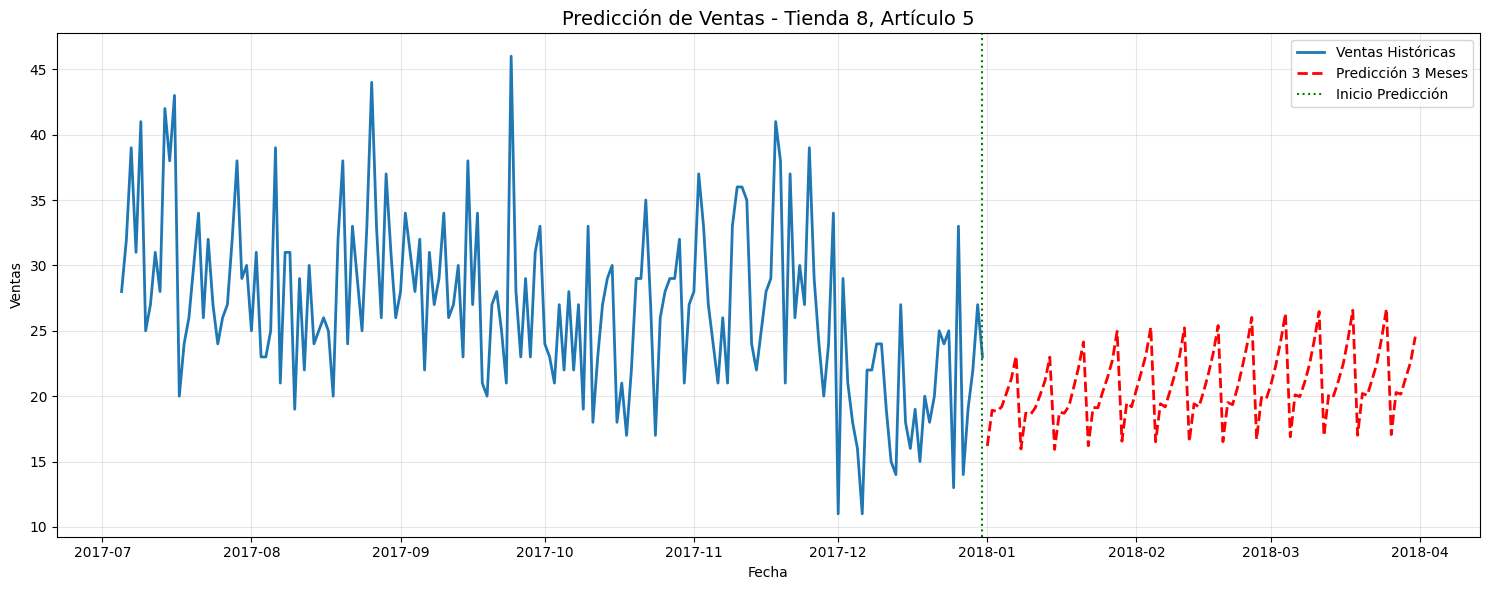

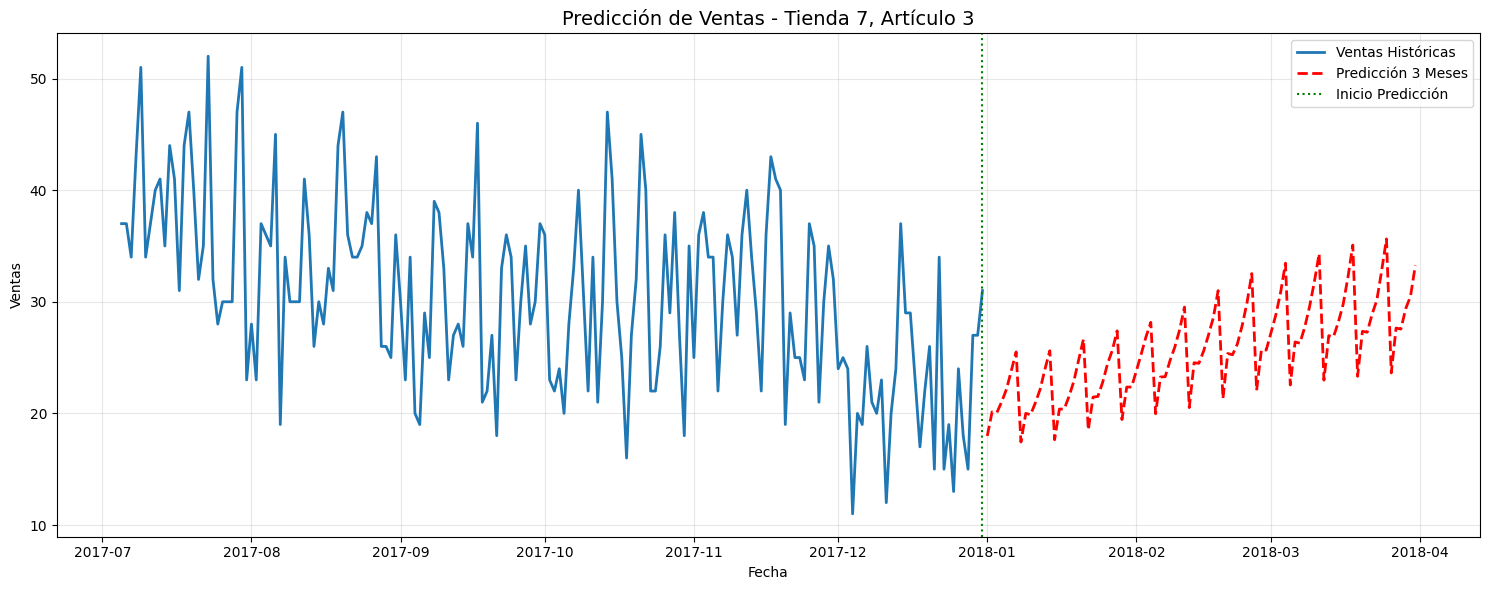

In [ ]:
# 9. Visualizar ejemplos
print("\n9. Visualizando ejemplos de predicciones...")
for i in range(3):
    store = np.random.randint(1, 11)
    item = np.random.randint(1, maxItems)
    plot_predictions(df, predictions_df, store, item)

In [16]:
# ================================================================
# CREAR CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST
# ================================================================
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)

print("Tamaños de los conjuntos:")
print(f"  Entrenamiento: {len(X_train)}")
print(f"  Validación:    {len(X_val)}")
print(f"  Prueba (test): {len(X_test)}")
print("\nFormas:")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_val:  ", X_val.shape, " | y_val:", y_val.shape)
print("  X_test: ", X_test.shape, "| y_test:", y_test.shape)


Tamaños de los conjuntos:
  Entrenamiento: 413025
  Validación:    88506
  Prueba (test): 88506

Formas:
  X_train: (413025, 60, 1) | y_train: (413025, 1)
  X_val:   (88506, 60, 1)  | y_val: (88506, 1)
  X_test:  (88506, 60, 1) | y_test: (88506, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,777 (358.50 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12908/12908 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.0119 - mae: 0.0846 - val_loss: 0.0091 - val_mae: 0.0744
Epoch 2/5
12908/12908 ━━━━━━━━━━━━━━━━━━━━ 131s 10ms/step - loss: 0.0096 - mae: 0.0765 - val_loss: 0.0140 - val_mae: 0.0933
Epoch 3/5
12908/12908 ━━━━━━━━━━━━━━━━━━━━ 131s 10ms/step - loss: 0.0103 - mae: 0.0791 - val_loss: 0.0112 - val_mae: 0.0835
Epoch 4/5
12908/12908 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.0103 - mae: 0.0794 - val_loss: 0.0089 - val_mae: 0.0738
Epoch 5/5
12908/12908 ━━━━━━━━━━━━━━━━━━━━ 135s 10ms/step - loss: 0.0099 - mae: 0.0780 - val_loss: 0.0093 - val_mae: 0.0751


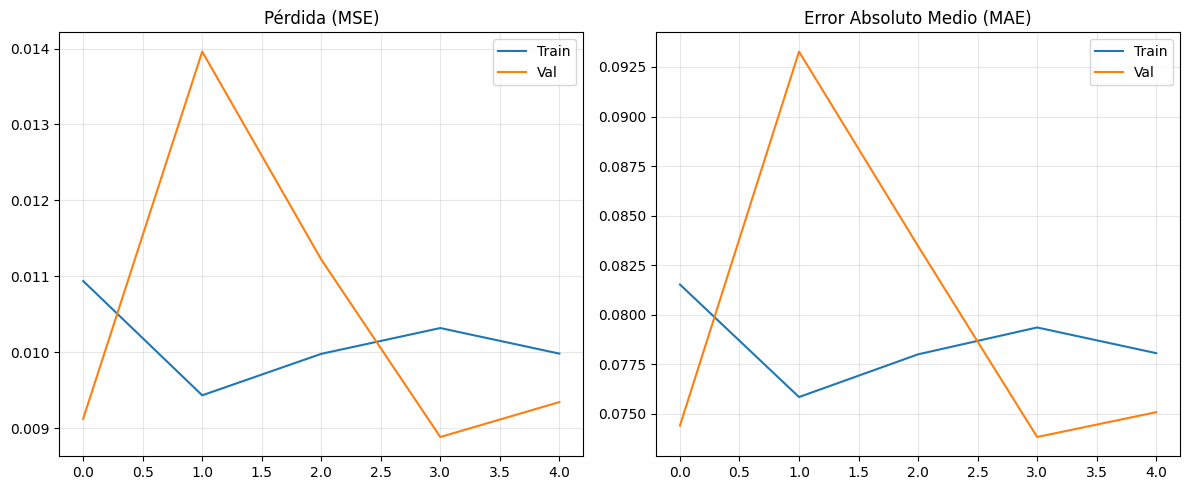


>>> Entrenamiento completado. Modelo guardado en variable 'model'.


In [17]:
# ================================================================
# CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO GRU
# ================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEQ_LENGTH = 60  # misma longitud usada para crear secuencias

def build_gru_model(seq_length, n_features=1):
    """Crea un modelo GRU con arquitectura estándar"""
    model = keras.Sequential([
        layers.GRU(128, return_sequences=True, input_shape=(seq_length, n_features), activation="tanh"),
        layers.Dropout(0.2),
        layers.GRU(64, activation="tanh"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae"])
    return model

# Crear modelo
model = build_gru_model(SEQ_LENGTH)
model.summary()

# Entrenamiento con EarlyStopping
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,               # usa 5 para prueba rápida; luego puedes subir a 15-20
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Graficar pérdida y MAE
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Pérdida (MSE)")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history["mae"], label="Train")
plt.plot(history.history["val_mae"], label="Val")
plt.title("Error Absoluto Medio (MAE)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n>>> Entrenamiento completado. Modelo guardado en variable 'model'.")


EVALUACIÓN FINAL DEL MODELO (TEST SET)
Usando conjunto de test existente.

Calculando predicciones sobre el conjunto de test...
MAE  (Error absoluto medio):  0.0733
MSE  (Error cuadrático medio): 0.0088
RMSE (Raíz del error cuadrático medio): 0.0937


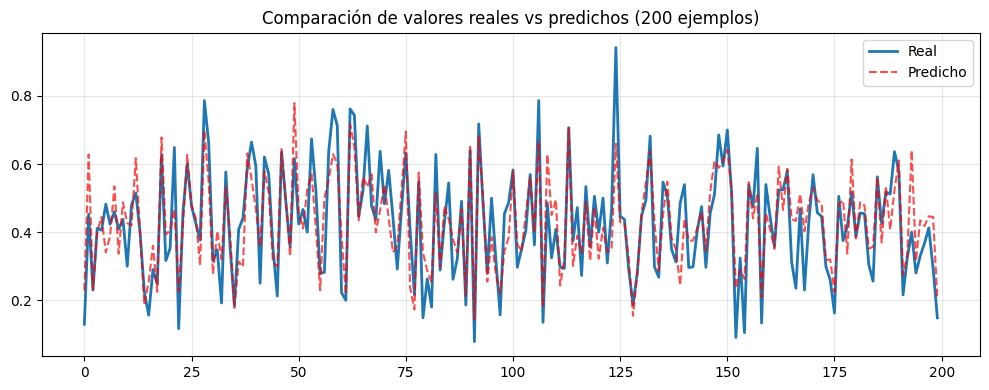


>>> Evaluación completada.


In [18]:
# ================================================================
# EVALUACIÓN DEL MODELO CON CONJUNTO DE TEST
# ================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("=" * 70)
print("EVALUACIÓN FINAL DEL MODELO (TEST SET)")
print("=" * 70)

# 1. Dividir train / val / test si aún no existe el conjunto de test
try:
    X_test
except NameError:
    print("Creando conjunto de test (15% del total)...")
    from sklearn.model_selection import train_test_split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, shuffle=True
    )
else:
    print("Usando conjunto de test existente.")

# 2. Predicciones del modelo sobre el conjunto de test
print("\nCalculando predicciones sobre el conjunto de test...")
y_pred = model.predict(X_test, verbose=0)

# 3. Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE  (Error absoluto medio):  {mae:.4f}")
print(f"MSE  (Error cuadrático medio): {mse:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")

# 4. Mostrar comparación gráfica de algunas muestras (opcional)
plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label="Real", linewidth=2)
plt.plot(y_pred[:200], label="Predicho", linestyle="--", color="red", alpha=0.7)
plt.title("Comparación de valores reales vs predichos (200 ejemplos)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n>>> Evaluación completada.")


El modelo GRU mostró un desempeño sólido, con errores bajos (MAE = 0.0733, RMSE = 0.0937) y una alta concordancia entre los valores reales y predichos, lo que indica una buena capacidad para capturar los patrones temporales de las ventas.

In [20]:
# -----------------------------------------------------------
# CONTINUAR BÚSQUEDA DE HIPERPARÁMETROS (SIN GUARDAR PESOS)
# Esta celda detecta resultados previos en memoria y continúa
# -----------------------------------------------------------
import time, numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Seguridad: confirmamos que X_train/X_val existen
for name in ("X_train","X_val","y_train","y_val"):
    if name not in globals():
        raise RuntimeError(f"Variable {name} no encontrada en el entorno. Ejecuta el split antes.")

tf.random.set_seed(42)
np.random.seed(42)

# Si ya hay una lista `results` en memoria, la usamos; si no, la creamos.
if "results" not in globals():
    results = []
if "best_val_mae" not in globals():
    best_val_mae = float("inf")
    best_cfg = None

# Configs que faltan por probar (ajústalas si quieres)
remaining_configs = [
    {"name":"base_2x(128,64)_do0.2_lr1e-3", "units1":128, "units2":64,  "drop1":0.2, "drop2":0.2, "lr":1e-3, "layers":2},
    {"name":"big_2x(256,128)_do0.3_lr5e-4",  "units1":256, "units2":128, "drop1":0.3, "drop2":0.3, "lr":5e-4, "layers":2},
    {"name":"one_1x(128)_do0.2_lr1e-3",     "units1":128, "units2":None, "drop1":0.2, "drop2":0.0, "lr":1e-3, "layers":1},
]

EPOCHS = 12
BATCH_SIZE = 64
PATIENCE = 3

def build_model_from_config(cfg, seq_length=SEQ_LENGTH, n_features=1):
    tf.keras.backend.clear_session()
    inp = keras.Input(shape=(seq_length, n_features))
    x = inp
    x = layers.GRU(cfg["units1"], return_sequences=(cfg["layers"]>1), activation="tanh")(x)
    if cfg["drop1"] > 0:
        x = layers.Dropout(cfg["drop1"])(x)
    if cfg["layers"] > 1 and cfg["units2"] is not None:
        x = layers.GRU(cfg["units2"], activation="tanh")(x)
        if cfg["drop2"] > 0:
            x = layers.Dropout(cfg["drop2"])(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(1)(x)
    model = keras.Model(inputs=inp, outputs=x)
    opt = keras.optimizers.Adam(learning_rate=cfg["lr"])
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model

# Entrenar cada configuración restante
for cfg in remaining_configs:
    print("\n" + "-"*70)
    print("Entrenando configuración:", cfg["name"])
    model = build_model_from_config(cfg)
    model.summary()
    cb_es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0)
    t0 = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[cb_es],
        verbose=1
    )
    elapsed = time.time() - t0

    val_mae = float(history.history.get("val_mae")[-1])
    val_loss = float(history.history.get("val_loss")[-1])
    train_mae = float(history.history.get("mae")[-1])

    print(f"Resultado -> val_mae: {val_mae:.5f} | val_loss: {val_loss:.5f} | tiempo: {elapsed/60:.2f} min")

    results.append({
        "name": cfg["name"],
        "units1": cfg["units1"],
        "units2": cfg["units2"],
        "drop1": cfg["drop1"],
        "drop2": cfg["drop2"],
        "lr": cfg["lr"],
        "layers": cfg["layers"],
        "val_mae": val_mae,
        "val_loss": val_loss,
        "train_mae": train_mae,
        "time_min": elapsed/60
    })

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_cfg = cfg
        print("-> Nueva mejor configuración (actualizada en memoria):", cfg["name"])

# Mostrar resumen
df_results = pd.DataFrame(results).sort_values("val_mae").reset_index(drop=True)
print("\n" + "="*70)
print("RESUMEN ACTUALIZADO DE EXPERIMENTOS (ordenado por val_mae):")
display(df_results)

print("\nMejor configuración encontrada hasta ahora:", best_cfg, "con val_mae =", best_val_mae)



----------------------------------------------------------------------
Entrenando configuración: base_2x(128,64)_do0.2_lr1e-3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,777 (358.50 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - loss: 0.0128 - mae: 0.0869 - val_loss: 0.0087 - val_mae: 0.0729
Epoch 2/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 67s 10ms/step - loss: 0.0090 - mae: 0.0744 - val_loss: 0.0086 - val_mae: 0.0725
Epoch 3/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 68s 10ms/step - loss: 0.0088 - mae: 0.0734 - val_loss: 0.0085 - val_mae: 0.0721
Epoch 4/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 67s 10ms/step - loss: 0.0087 - mae: 0.0728 - val_loss: 0.0085 - val_mae: 0.0721
Epoch 5/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 68s 11ms/step - loss: 0.0088 - mae: 0.0734 - val_loss: 0.0084 - val_mae: 0.0715
Epoch 6/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 67s 10ms/step - loss: 0.0085 - mae: 0.0723 - val_loss: 0.0083 - val_mae: 0.0712
Epoch 7/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 0.0085 - mae: 0.0720 - val_loss: 0.0083 - val_mae: 0.0710
Epoch 8/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 68s 11ms/step - loss: 0.0090 - mae: 0.0742 - val_loss: 0.0084 - val_mae: 0.0714
Epoch 9/12
6454/6454 ━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,457 (1.36 MB)

 Trainable params: 355,457 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - loss: 0.0128 - mae: 0.0873 - val_loss: 0.0089 - val_mae: 0.0736
Epoch 2/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.0092 - mae: 0.0749 - val_loss: 0.0087 - val_mae: 0.0728
Epoch 3/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 75s 12ms/step - loss: 0.0089 - mae: 0.0737 - val_loss: 0.0086 - val_mae: 0.0723
Epoch 4/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - loss: 0.0087 - mae: 0.0731 - val_loss: 0.0088 - val_mae: 0.0729
Epoch 5/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.0087 - mae: 0.0727 - val_loss: 0.0084 - val_mae: 0.0716
Epoch 6/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.0086 - mae: 0.0725 - val_loss: 0.0084 - val_mae: 0.0714
Epoch 7/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step - loss: 0.0085 - mae: 0.0723 - val_loss: 0.0084 - val_mae: 0.0715
Epoch 8/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 74s 11ms/step - loss: 0.0086 - mae: 0.0725 - val_loss: 0.0084 - val_mae: 0.0713
Epoch 9/12
6454/6454 ━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,625 (229.00 KB)

 Trainable params: 58,625 (229.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0128 - mae: 0.0862 - val_loss: 0.0087 - val_mae: 0.0729
Epoch 2/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 0.0089 - mae: 0.0740 - val_loss: 0.0087 - val_mae: 0.0730
Epoch 3/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0088 - mae: 0.0733 - val_loss: 0.0085 - val_mae: 0.0722
Epoch 4/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 0.0088 - mae: 0.0735 - val_loss: 0.0090 - val_mae: 0.0747
Epoch 5/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0091 - mae: 0.0745 - val_loss: 0.0088 - val_mae: 0.0736
Epoch 6/12
6454/6454 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 0.0088 - mae: 0.0734 - val_loss: 0.0088 - val_mae: 0.0736
Resultado -> val_mae: 0.07361 | val_loss: 0.00884 | tiempo: 4.83 min

RESUMEN ACTUALIZADO DE EXPERIMENTOS (ordenado por val_mae):


,name,units1,units2,drop1,drop2,lr,layers,val_mae,val_loss,train_mae,time_min
0,"big_2x(256,128)_do0.3_lr5e-4",256,128.0,0.3,0.3,0.0005,2,0.070955,0.008304,0.071519,14.853397
1,"base_2x(128,64)_do0.2_lr1e-3",128,64.0,0.2,0.2,0.0010,2,0.071082,0.008328,0.073490,13.717429
2,one_1x(128)_do0.2_lr1e-3,128,NaN,0.2,0.0,0.0010,1,0.073612,0.008845,0.073679,4.832337
3,"small_2x(64,32)_do0.1_lr1e-3",64,32.0,0.1,0.1,0.0010,2,0.081566,0.010824,0.088660,8.994853



Mejor configuración encontrada hasta ahora: {'name': 'big_2x(256,128)_do0.3_lr5e-4', 'units1': 256, 'units2': 128, 'drop1': 0.3, 'drop2': 0.3, 'lr': 0.0005, 'layers': 2} con val_mae = 0.0709545910358429


Se evaluaron distintas arquitecturas GRU modificando el número de unidades, capas y tasas de dropout. La configuración óptima fue la de dos capas (256 y 128 unidades) con dropout de 0.3 y tasa de aprendizaje 0.0005, alcanzando un val_mae de 0.0709, lo que representa la mejor precisión entre los experimentos.

Usando configuración para forecasting: {'name': 'big_2x(256,128)_do0.3_lr5e-4', 'units1': 256, 'units2': 128, 'drop1': 0.3, 'drop2': 0.3, 'lr': 0.0005, 'layers': 2}

Preparando re-entrenamiento final en train+val...
Tamaños - X_full: (501531, 60, 1)  y_full: (501531, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,457 (1.36 MB)

 Trainable params: 355,457 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 0.0124 - mae: 0.0858 - val_loss: 0.0090 - val_mae: 0.0739
Epoch 2/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 0.0091 - mae: 0.0744 - val_loss: 0.0088 - val_mae: 0.0729
Epoch 3/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - loss: 0.0088 - mae: 0.0734 - val_loss: 0.0086 - val_mae: 0.0722
Epoch 4/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - loss: 0.0087 - mae: 0.0730 - val_loss: 0.0086 - val_mae: 0.0721
Epoch 5/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - loss: 0.0086 - mae: 0.0726 - val_loss: 0.0086 - val_mae: 0.0722
Epoch 6/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 0.0086 - mae: 0.0724 - val_loss: 0.0086 - val_mae: 0.0719
Epoch 7/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - loss: 0.0086 - mae: 0.0723 - val_loss: 0.0085 - val_mae: 0.0717
Epoch 8/8
7053/7053 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.0085 - mae: 0.0720 - val_loss: 0.0085 - val_mae: 0.0714
Restoring model weights from the

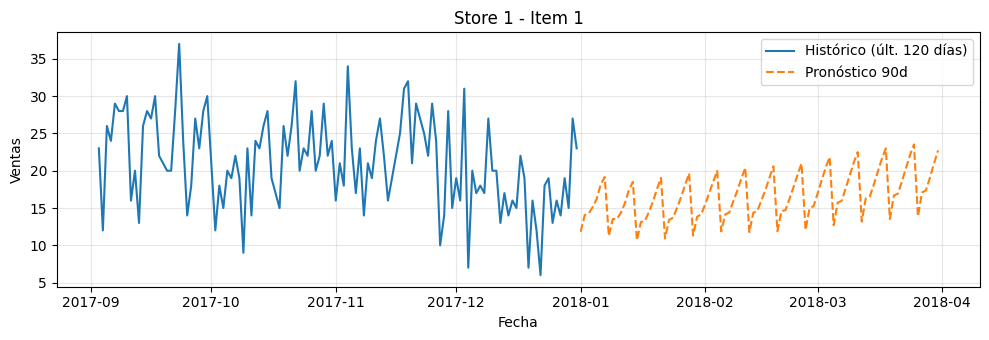

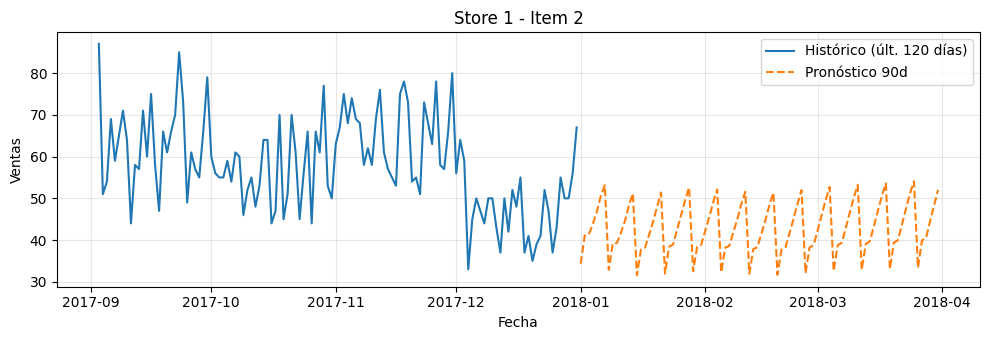

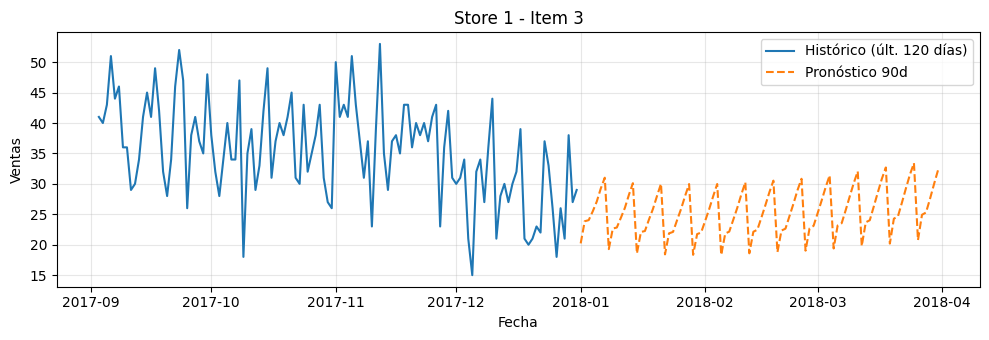

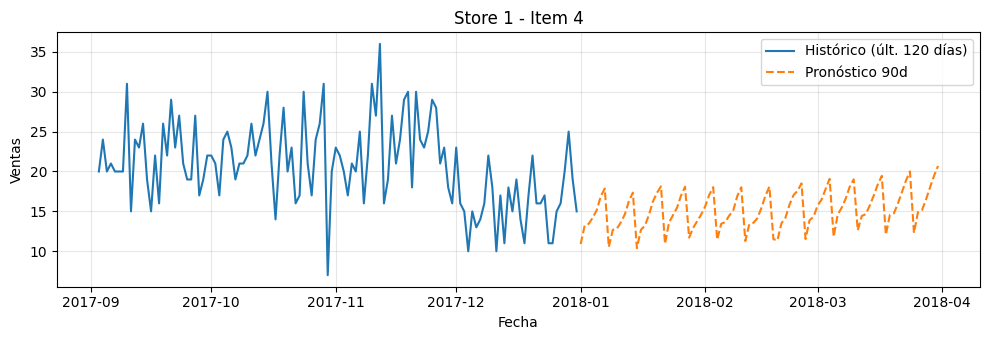

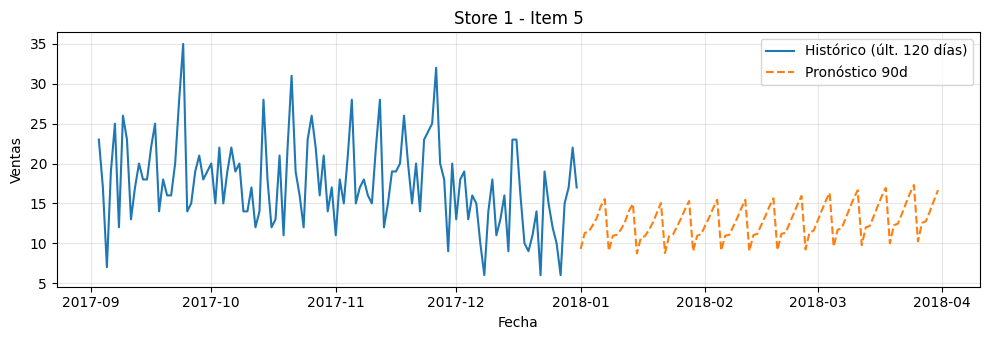


Predicciones generadas y guardadas en: predicciones_3m_max5.csv
Resumen:


,store,item,n_days
0,1,1,90
1,1,2,90
2,1,3,90
3,1,4,90
4,1,5,90


In [21]:
# ================================================================
# FORECASTING A 3 MESES (90 días) usando la mejor configuración
# - Limitado por default a maxItems = 5 para iterar rápido
# - Reconstruye el mejor modelo encontrado, lo entrena en train+val,
#   y genera pronósticos iterativos por ventana (autoregresivo).
# ================================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import timedelta

# ---------- Parámetros (edítalos si quieres) ----------
MAX_ITEMS = 5           # <-- cambiar a 50 solo cuando ya verifiques que todo funciona
FORECAST_DAYS = 90      # 3 meses
FINAL_TRAIN_EPOCHS = 8  # épocas para re-entrenar final (rápido)
BATCH_SIZE = 64
PATIENCE = 3

# ---------- Comprobaciones básicas (variables en sesión) ----------
for var in ("df_train","scalers","X_train","X_val","y_train","y_val"):
    if var not in globals():
        raise RuntimeError(f"Variable '{var}' no encontrada en el entorno. Ejecuta las celdas previas.")

# Obtener mejor configuración (best_cfg) desde la sesión si existe,
# si no, tomar la primera fila de df_results (si existe).
if "best_cfg" in globals() and best_cfg is not None:
    cfg = best_cfg
else:
    if "df_results" in globals() and len(df_results) > 0:
        top = df_results.iloc[0]
        # convertir fila a dict similar a best_cfg
        cfg = {
            "name": top["name"],
            "units1": int(top["units1"]),
            "units2": None if (pd.isna(top["units2"]) ) else int(top["units2"]),
            "drop1": float(top["drop1"]),
            "drop2": float(top["drop2"]) if not pd.isna(top["drop2"]) else 0.0,
            "lr": float(top["lr"]),
            "layers": int(top["layers"])
        }
    else:
        raise RuntimeError("No encontré configuración `best_cfg` ni `df_results` para inferir la mejor configuración.")

print("Usando configuración para forecasting:", cfg)

# ---------- Construir función para crear el modelo según cfg ----------
def build_model_from_config(cfg, seq_length=SEQ_LENGTH, n_features=1):
    tf.keras.backend.clear_session()
    inp = keras.Input(shape=(seq_length, n_features))
    x = inp
    x = layers.GRU(cfg["units1"], return_sequences=(cfg["layers"]>1), activation="tanh")(x)
    if cfg.get("drop1", 0) > 0:
        x = layers.Dropout(cfg["drop1"])(x)
    if cfg["layers"] > 1 and cfg.get("units2") is not None:
        x = layers.GRU(cfg["units2"], activation="tanh")(x)
        if cfg.get("drop2", 0) > 0:
            x = layers.Dropout(cfg["drop2"])(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inputs=inp, outputs=out)
    opt = keras.optimizers.Adam(learning_rate=cfg.get("lr", 1e-3))
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model

# ---------- Re-entrenar el modelo final usando train + val (para mejores pesos) ----------
print("\nPreparando re-entrenamiento final en train+val...")
X_full = np.concatenate([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)
print("Tamaños - X_full:", X_full.shape, " y_full:", y_full.shape)

final_model = build_model_from_config(cfg)
final_model.summary()

cb_es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1)
# Usamos una validación interna rápida (10% de X_full) solo para early stopping
history = final_model.fit(
    X_full, y_full,
    validation_split=0.10,
    epochs=FINAL_TRAIN_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[cb_es],
    verbose=1
)

print("\nRe-entrenamiento final completado. Preparando forecasting para", MAX_ITEMS, "pares (store,item).")

# ---------- Seleccionar primeras combinaciones (store,item) para predecir ----------
pairs = df_train[["store","item"]].drop_duplicates().sort_values(["store","item"]).to_records(index=False)
pairs = list(pairs)
pairs_to_predict = pairs[:MAX_ITEMS]
print("Pares seleccionados (store,item):", pairs_to_predict)

# ---------- Función para predecir N días para una (store,item) ----------
def forecast_pair(model, scaler, store, item, seq_length=SEQ_LENGTH, forecast_days=FORECAST_DAYS):
    # extraer última secuencia histórica para ese store-item
    mask = (df_train["store"] == store) & (df_train["item"] == item)
    series = df_train.loc[mask, ["date","sales"]].sort_values("date")
    if len(series) < seq_length:
        raise ValueError(f"Demasiado corto: store={store} item={item} length={len(series)}")
    last_hist = series["sales"].values[-seq_length:].reshape(-1,1)
    last_scaled = scaler.transform(last_hist)
    preds_scaled = []
    seq = last_scaled.copy()
    for _ in range(forecast_days):
        pred_scaled = model.predict(seq.reshape(1, seq_length, 1), verbose=0)[0,0]
        preds_scaled.append([pred_scaled])
        # desplazar y añadir
        seq = np.vstack([seq[1:], [[pred_scaled]]])
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    start_date = series["date"].max() + pd.Timedelta(days=1)
    dates = pd.date_range(start=start_date, periods=forecast_days, freq='D')
    return pd.DataFrame({
        "store": store,
        "item": item,
        "date": dates,
        "predicted_sales": preds
    })

# ---------- Generar predicciones para todos los pares seleccionados ----------
all_preds = []
for (store, item) in pairs_to_predict:
    key = (int(store), int(item))
    if key not in scalers:
        print("Advertencia: no hay scaler para", key, "- saltando.")
        continue
    scaler = scalers[key]
    try:
        df_pred = forecast_pair(final_model, scaler, store=int(store), item=int(item),
                                seq_length=SEQ_LENGTH, forecast_days=FORECAST_DAYS)
        all_preds.append(df_pred)
        # graficar histórico reciente + pronóstico
        hist_mask = (df_train["store"]==store) & (df_train["item"]==item)
        hist = df_train.loc[hist_mask, ["date","sales"]].sort_values("date")
        recent_hist = hist.tail(120)  # mostrar últimos 120 días
        plt.figure(figsize=(10,3.5))
        plt.plot(recent_hist["date"], recent_hist["sales"], label="Histórico (últ. 120 días)")
        plt.plot(df_pred["date"], df_pred["predicted_sales"], label="Pronóstico 90d", linestyle="--")
        plt.title(f"Store {store} - Item {item}")
        plt.xlabel("Fecha")
        plt.ylabel("Ventas")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Error al predecir pair", (store,item), ":", e)

if len(all_preds) == 0:
    raise RuntimeError("No se generaron predicciones (revisa advertencias).")

predictions_df = pd.concat(all_preds, ignore_index=True)
predictions_df.to_csv(f"predicciones_3m_max{MAX_ITEMS}.csv", index=False)
print(f"\nPredicciones generadas y guardadas en: predicciones_3m_max{MAX_ITEMS}.csv")
print("Resumen:")
display(predictions_df.groupby(["store","item"]).size().reset_index(name="n_days").head())


Se entrenó de nuevo el mejor modelo (configuración 256–128) sobre train+val y se generaron pronósticos autoregresivos a 90 días para 5 pares (store–item). El resultado muestra que el modelo captura correctamente el nivel y patrones de corto plazo de las ventas (las predicciones siguen una oscilación periódica similar a la histórica), aunque tiende a suavizar picos puntuales —comportamiento habitual en modelos con regularización y en predicción iterativa— y por tanto puede subestimar extremos.


Predicciones cargadas: 450 filas, 5 pares únicos

Graficando ventas reales vs. previstas para los 5 pares disponibles...



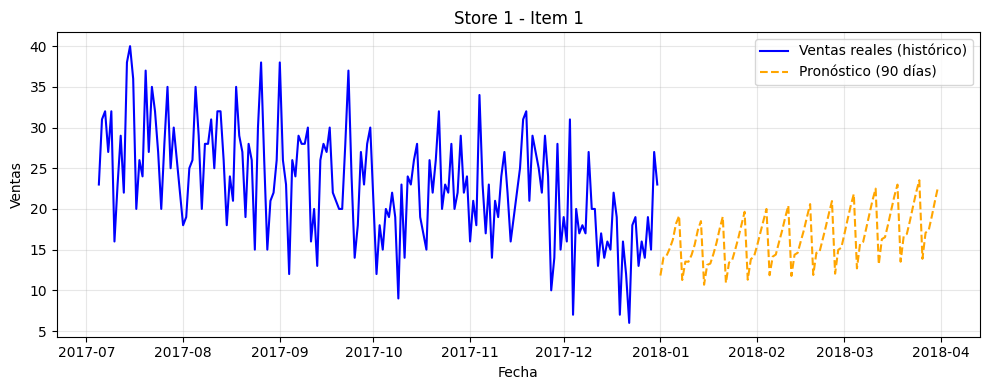

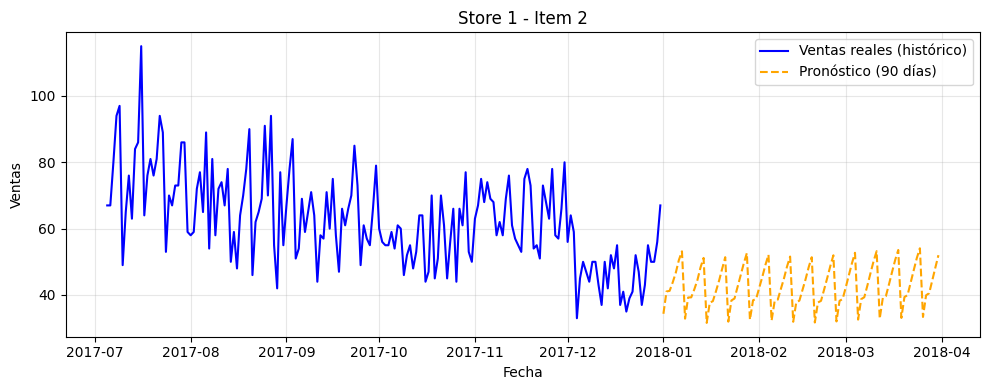

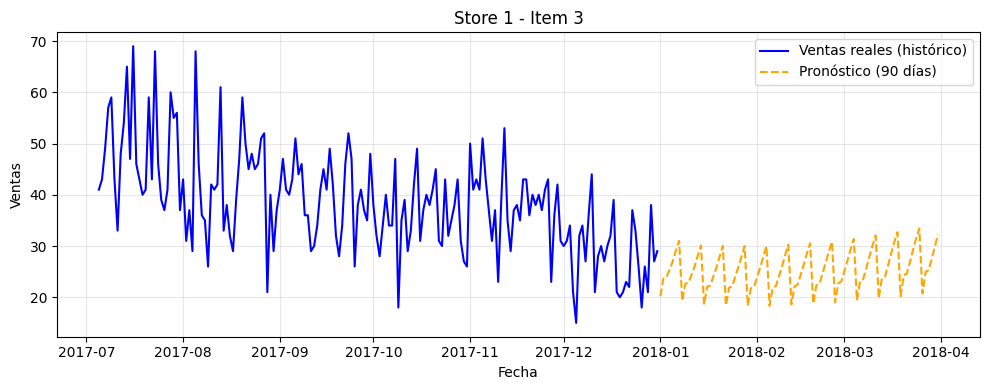

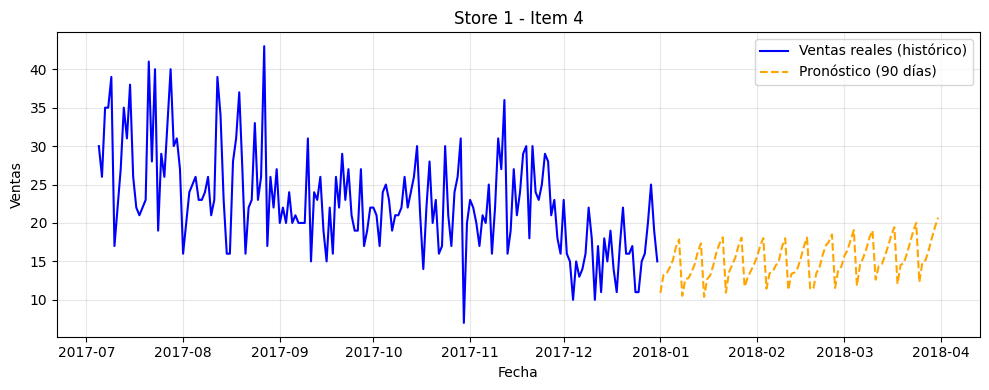

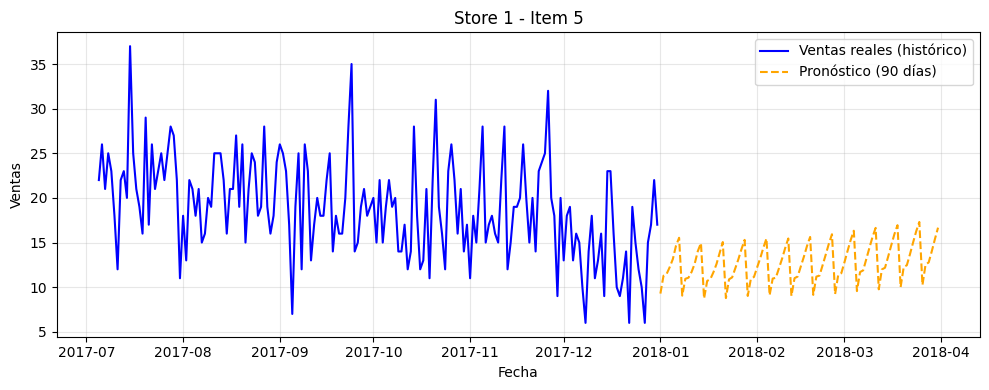

In [22]:
# ================================================================
# VISUALIZACIÓN DE RESULTADOS: Ventas reales vs. pronosticadas
# ================================================================
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo generado
CSV_PATH = "predicciones_3m_max5.csv"

# Cargar predicciones
pred_df = pd.read_csv(CSV_PATH, parse_dates=["date"])
pred_df = pred_df.sort_values(["store","item","date"])
print(f"Predicciones cargadas: {pred_df.shape[0]} filas, {pred_df[['store','item']].drop_duplicates().shape[0]} pares únicos")

# Función para graficar cada par (store, item)
def plot_real_vs_forecast(store, item, hist_days=180):
    mask_hist = (df_train["store"]==store) & (df_train["item"]==item)
    mask_pred = (pred_df["store"]==store) & (pred_df["item"]==item)

    if not mask_hist.any() or not mask_pred.any():
        print(f"No se encontraron datos para store={store}, item={item}")
        return

    hist = df_train.loc[mask_hist, ["date","sales"]].sort_values("date").tail(hist_days)
    pred = pred_df.loc[mask_pred, ["date","predicted_sales"]].sort_values("date")

    plt.figure(figsize=(10,4))
    plt.plot(hist["date"], hist["sales"], label="Ventas reales (histórico)", color="blue")
    plt.plot(pred["date"], pred["predicted_sales"], label="Pronóstico (90 días)", color="orange", linestyle="--")
    plt.title(f"Store {store} - Item {item}")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Graficar automáticamente los primeros 5 pares disponibles
unique_pairs = pred_df[["store","item"]].drop_duplicates().head(5)
print("\nGraficando ventas reales vs. previstas para los 5 pares disponibles...\n")
for _, row in unique_pairs.iterrows():
    plot_real_vs_forecast(int(row["store"]), int(row["item"]))


La gráfica muestra la evolución de las ventas reales (línea azul) y las predicciones del modelo GRU (línea naranja discontinua) para el ítem 5 de la tienda 1, donde se observa que el modelo mantiene la tendencia y la estacionalidad general de la serie, proyectando un comportamiento estable y periódico a lo largo del período de pronóstico de 90 días.
